# Introduction and some imports

This notebook was created for educational purposes as a final project for course "". Here I'll tune several pre-trained models (ResNet18, Google-net, ResNeXt), create my own small convolutional neural network with pytorch, and compare their performance. [Here](https://www.kaggle.com/datasets/gpiosenka/100-bird-species) is the dataset used for this project.

This notebook is compiled from several versions, since I have trained my models at different devices, and introduced minor changes as well. Therefore output from cells at the beginning may be a little bit different than at the end of notebook. That's why I had to compile several functions outputs by hand to plot charts as well.

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision import transforms
from torchvision.transforms import v2
from PIL import Image

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, roc_curve, r2_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import compute_class_weight
#import umap

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Data loading and cleaning

In [ ]:
batch_size = 64
resize_scale = 224, 224

In [ ]:
df = pd.read_csv('data/birds.csv')

In [ ]:
df.head()

,class id,filepaths,labels,data set,scientific name
0,0.0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0.0,train/ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0.0,train/ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0.0,train/ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0.0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI


Some correction is required. There is a mistype in 'PARAKETT  AKULET', and some files have wrong paths for them.

In [ ]:
df.query('labels == "PARAKETT  AKULET"')

,class id,filepaths,labels,data set,scientific name
59400,373.0,train/PARAKETT AKULET/038.jpg,PARAKETT AKULET,train,AETHIA PSITTACULA
59401,373.0,train/PARAKETT AKULET/079.jpg,PARAKETT AKULET,train,AETHIA PSITTACULA
59402,373.0,train/PARAKETT AKULET/137.jpg,PARAKETT AKULET,train,AETHIA PSITTACULA
59403,373.0,train/PARAKETT AKULET/128.jpg,PARAKETT AKULET,train,AETHIA PSITTACULA
59404,373.0,train/PARAKETT AKULET/005.jpg,PARAKETT AKULET,train,AETHIA PSITTACULA
...,...,...,...,...,...
89125,373.0,valid/PARAKETT AKULET/4.jpg,PARAKETT AKULET,valid,AETHIA PSITTACULA
89126,373.0,valid/PARAKETT AKULET/3.jpg,PARAKETT AKULET,valid,AETHIA PSITTACULA
89127,373.0,valid/PARAKETT AKULET/5.jpg,PARAKETT AKULET,valid,AETHIA PSITTACULA
89128,373.0,valid/PARAKETT AKULET/1.jpg,PARAKETT AKULET,valid,AETHIA PSITTACULA


In [ ]:
df['labels'] = df['labels'].str.replace('PARAKETT  AKULET', 'PARAKEET AUKLET') # here is the right name
df['filepaths'] = df['filepaths'].str.replace('AKULET', 'AUKLET') # and here is the path to folders

In [ ]:
df.loc[df['class id'] == 373]['filepaths']

59400    train/PARAKETT  AUKLET/038.jpg
59401    train/PARAKETT  AUKLET/079.jpg
59402    train/PARAKETT  AUKLET/137.jpg
59403    train/PARAKETT  AUKLET/128.jpg
59404    train/PARAKETT  AUKLET/005.jpg
                      ...              
89125      valid/PARAKETT  AUKLET/4.jpg
89126      valid/PARAKETT  AUKLET/3.jpg
89127      valid/PARAKETT  AUKLET/5.jpg
89128      valid/PARAKETT  AUKLET/1.jpg
89129      valid/PARAKETT  AUKLET/2.jpg
Name: filepaths, Length: 165, dtype: object

In [ ]:
df_train = df[['filepaths', 'class id']].loc[df['data set'] == 'train']
df_valid = df[['filepaths', 'class id']].loc[df['data set'] == 'valid']
df_test = df[['filepaths', 'class id']].loc[df['data set'] == 'test']

In [ ]:
df_valid['filepaths'] = df_valid['filepaths'].str.replace('PARAKETT  AUKLET', 'PARAKETT AUKLET') # and in the validation part the folder have one space.

In [ ]:
df_valid['filepaths'].loc[df_valid['class id'] == 373]

89125    valid/PARAKETT AUKLET/4.jpg
89126    valid/PARAKETT AUKLET/3.jpg
89127    valid/PARAKETT AUKLET/5.jpg
89128    valid/PARAKETT AUKLET/1.jpg
89129    valid/PARAKETT AUKLET/2.jpg
Name: filepaths, dtype: object

In [ ]:
df_train['class id'].unique().size, df_train.shape, df_valid.shape, df_test.shape

(525, (84635, 2), (2625, 2), (2625, 2))

Maybe it could be reasonable to create our own test and validation datasets, but for now I'll stick to the author's.

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir):
        self.img_labels = annotations_file
        self.img_dir = img_dir

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        # image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(size=resize_scale),
            
            ])
        image = transform(image)
        return image, label

In [ ]:
train_dataset = CustomImageDataset(df_train, 'data')
valid_dataset = CustomImageDataset(df_valid, 'data')
test_dataset = CustomImageDataset(df_test, 'data')

In [ ]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

The dataset seems to be ready for training!

# Training functions

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    train_loss = 0
    num_batches = len(dataloader)
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.type(torch.LongTensor).to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss

        model.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            print(f'Loss is:{loss.item()} [{(batch +1) * len(X)}/{len(dataloader.dataset)}]')
    train_loss = (train_loss / num_batches).item()
    return train_loss

In [ ]:
def test(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    correct = 0
    f1 = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.type(torch.LongTensor).to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            f1 += f1_score(y.cpu(), pred.argmax(1).cpu(), average='weighted')
    test_loss = (test_loss / num_batches).item()
    accuracy = correct / size
    f1 = (f1 / num_batches).item()
    #print(f'Test accuracy: {accuracy * 100}%, average F1 score: {f1} avg loss: {test_loss} \n')
    return accuracy, f1, test_loss

In [ ]:
def train_and_test(train_dataloader, test_dataloader, model, loss_fn, optimizer, n_epochs=1):
    accuracy = []
    test_loss = []
    train_loss = []
    f1 = []
    for t in range(n_epochs):
        print(f'------------Epoch {t + 1}------------')
        train_metrics = train(train_dataloader, model, loss_fn, optimizer)
        train_loss += [train_metrics]
        test_metrics = test(test_dataloader, model, loss_fn)
        accuracy += [test_metrics[0]]
        f1 += [test_metrics[1]]
        test_loss += [test_metrics[2]]
        print(f'Test accuracy: {accuracy[-1] * 100}%, average F1 score: {f1[-1]}, avg loss: {test_loss[-1]} \n')
    print('Done!')
    return accuracy, f1, train_loss, test_loss

# Tuning models for comparison

I decided to test several pretrained models: GoogleNet, ResNet (or ResNeXt?), model provided with the dataset (EfficientNetB0). And then I can create my own model as well, with some similarity for those models, and train it to see if it will be viable.

I'll start with the smallest ResNet model.

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights
resnet_small = resnet18(weights=ResNet18_Weights.DEFAULT)
resnet_small

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Modify the last layer for 525 classes
resnet_small.fc = nn.Linear(resnet_small.fc.in_features, 525)
resnet_small.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Freeze all layers
for param in resnet_small.parameters():
    param.requires_grad = False

# Unfreeze the fully connected layer
for param in resnet_small.fc.parameters():
    param.requires_grad = True

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_small.parameters(), lr=1e-1)
accuracy_resnet, train_loss_resnet, test_loss_resnet  = train_and_test(
    train_dataloader=train_dataloader,
    test_dataloader=valid_dataloader,
    model=resnet_small,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=4)

------------Epoch 1------------
Loss is:6.526485443115234 [64/84635]


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Loss is:151.79458618164062 [6464/84635]
Loss is:48.23097610473633 [12864/84635]
Loss is:31.228164672851562 [19264/84635]
Loss is:24.025880813598633 [25664/84635]
Loss is:19.935544967651367 [32064/84635]
Loss is:28.013654708862305 [38464/84635]
Loss is:25.68901252746582 [44864/84635]
Loss is:27.207256317138672 [51264/84635]
Loss is:9.65837287902832 [57664/84635]
Loss is:28.387807846069336 [64064/84635]
Loss is:39.878990173339844 [70464/84635]
Loss is:24.191875457763672 [76864/84635]
Loss is:15.703424453735352 [83264/84635]
Test accuracy: 64.72380952380952%, avg loss: 19.309946060180664 

------------Epoch 2------------
Loss is:24.471847534179688 [64/84635]
Loss is:19.222320556640625 [6464/84635]
Loss is:23.55594825744629 [12864/84635]
Loss is:30.66232681274414 [19264/84635]
Loss is:18.422016143798828 [25664/84635]
Loss is:19.567350387573242 [32064/84635]
Loss is:19.353395462036133 [38464/84635]
Loss is:22.30339241027832 [44864/84635]
Loss is:19.627941131591797 [51264/84635]
Loss is:17.2

In [ ]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-3
tup = train_and_test(
    train_dataloader=train_dataloader,
    test_dataloader=valid_dataloader,
    model=resnet_small,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=3)
accuracy_resnet += tup[0]
train_loss_resnet += tup[1]
test_loss_resnet += tup[2]

------------Epoch 1------------
Loss is:23.89333152770996 [64/84635]
Loss is:11.178067207336426 [6464/84635]
Loss is:5.387243270874023 [12864/84635]
Loss is:7.138980388641357 [19264/84635]
Loss is:11.460298538208008 [25664/84635]
Loss is:1.8261387348175049 [32064/84635]
Loss is:5.309385299682617 [38464/84635]
Loss is:8.946711540222168 [44864/84635]
Loss is:4.505452632904053 [51264/84635]
Loss is:4.065105438232422 [57664/84635]
Loss is:5.025441646575928 [64064/84635]
Loss is:7.798300266265869 [70464/84635]
Loss is:4.546427249908447 [76864/84635]
Loss is:6.88075065612793 [83264/84635]
Test accuracy: 87.31428571428572%, avg loss: 9.261615753173828 

------------Epoch 2------------
Loss is:4.266311168670654 [64/84635]
Loss is:3.0871827602386475 [6464/84635]
Loss is:3.464677572250366 [12864/84635]
Loss is:3.755397319793701 [19264/84635]
Loss is:7.0676679611206055 [25664/84635]
Loss is:9.270496368408203 [32064/84635]
Loss is:5.224837779998779 [38464/84635]
Loss is:7.431926250457764 [44864/84

In [ ]:
torch.save(resnet_small, '/kaggle/working/resnet_small.pth')

In [ ]:
test(test_dataloader, resnet_small, loss_fn)

(0.8967619047619048, 5.794475078582764)

Text(0.5, 1.0, 'ResNet18')

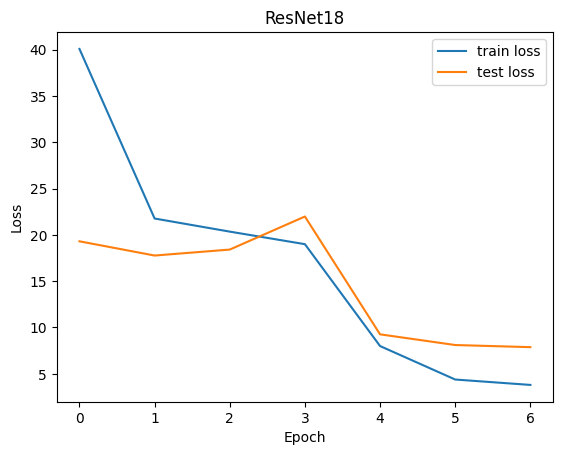

In [ ]:
plt.plot(train_loss_resnet, label='train loss')
plt.plot(test_loss_resnet, label='test loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet18')

It is amasing, actually I thought that this neural network will be too small for this task. However we have 90% accuracy for training data after training for only 6 epochs!

I tried adding two layers to the output of this network but it stopped training.
Let's try something huge, and then I'll create my own network.

In [ ]:
from torchvision.models import googlenet, GoogLeNet_Weights
google_model = googlenet(weights=GoogLeNet_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:01<00:00, 51.2MB/s]


In [ ]:
google_model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
google_model.fc = nn.Linear(google_model.fc.in_features, 525)
# Freeze all layers
for param in google_model.parameters():
    param.requires_grad = False

# Unfreeze the fully connected layer
for param in google_model.fc.parameters():
    param.requires_grad = True

In [ ]:
google_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(google_model.parameters(), lr=1e-1)
accuracy_google, train_loss_google, test_loss_google = train_and_test(
    train_dataloader=train_dataloader,
    test_dataloader=valid_dataloader,
    model=google_model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=3)

------------Epoch 1------------
Loss is:6.316164016723633 [64/84635]
Loss is:88.2721939086914 [6464/84635]
Loss is:26.25192642211914 [12864/84635]
Loss is:29.23110008239746 [19264/84635]
Loss is:27.596572875976562 [25664/84635]
Loss is:24.67656707763672 [32064/84635]
Loss is:22.157913208007812 [38464/84635]
Loss is:34.17927169799805 [44864/84635]
Loss is:26.721519470214844 [51264/84635]
Loss is:26.056133270263672 [57664/84635]
Loss is:35.21004104614258 [64064/84635]
Loss is:32.413333892822266 [70464/84635]
Loss is:21.259830474853516 [76864/84635]
Loss is:31.578596115112305 [83264/84635]
Test accuracy: 66.74285714285715%, avg loss: 14.937468528747559 

------------Epoch 2------------
Loss is:21.22614097595215 [64/84635]
Loss is:22.984228134155273 [6464/84635]
Loss is:23.33366584777832 [12864/84635]
Loss is:27.68076515197754 [19264/84635]
Loss is:26.30504035949707 [25664/84635]
Loss is:16.931041717529297 [32064/84635]
Loss is:24.889781951904297 [38464/84635]
Loss is:24.930438995361328 [4

In [ ]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-3
tup = train_and_test(
    train_dataloader=train_dataloader,
    test_dataloader=valid_dataloader,
    model=google_model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=3)
accuracy_google += tup[0]
train_loss_google += tup[1]
test_loss_google += tup[2]

------------Epoch 1------------
Loss is:21.949670791625977 [64/84635]
Loss is:19.799161911010742 [6464/84635]
Loss is:6.384537696838379 [12864/84635]
Loss is:25.439300537109375 [19264/84635]
Loss is:14.85576343536377 [25664/84635]
Loss is:11.02086067199707 [32064/84635]
Loss is:8.997502326965332 [38464/84635]
Loss is:9.171209335327148 [44864/84635]
Loss is:6.280849456787109 [51264/84635]
Loss is:9.388593673706055 [57664/84635]
Loss is:11.351845741271973 [64064/84635]
Loss is:7.760166168212891 [70464/84635]
Loss is:12.848405838012695 [76864/84635]
Loss is:3.8722972869873047 [83264/84635]
Test accuracy: 86.20952380952382%, avg loss: 7.213720321655273 

------------Epoch 2------------
Loss is:5.268373966217041 [64/84635]
Loss is:8.391983985900879 [6464/84635]
Loss is:11.105652809143066 [12864/84635]
Loss is:9.668169975280762 [19264/84635]
Loss is:4.458277702331543 [25664/84635]
Loss is:4.624283313751221 [32064/84635]
Loss is:7.728841781616211 [38464/84635]
Loss is:8.197866439819336 [44864

In [ ]:
torch.save(google_model, '/kaggle/working/google_model.pth')

In [ ]:
test(test_dataloader, google_model, loss_fn)

(0.8822857142857143, 4.986644744873047)

Text(0, 0.5, 'Loss')

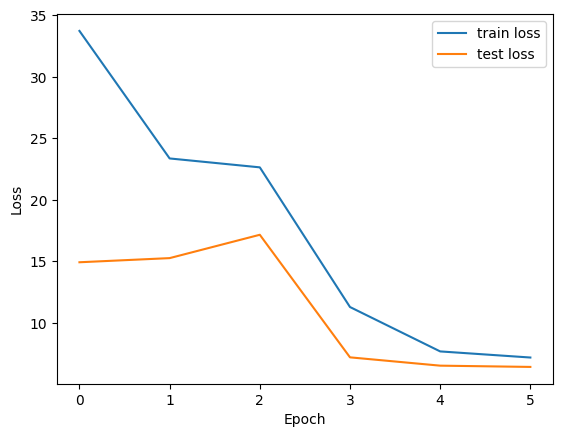

In [ ]:
plt.plot(train_loss_google, label='train loss')
plt.plot(test_loss_google, label='test loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
from torchvision.models import resnext101_32x8d, ResNeXt101_32X8D_Weights
resnext_model = resnext101_32x8d(weights=ResNeXt101_32X8D_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-110c445d.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-110c445d.pth
100%|██████████| 340M/340M [00:04<00:00, 79.7MB/s]


In [ ]:
resnext_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [ ]:
resnext_model.fc = nn.Linear(resnext_model.fc.in_features, 525)
# Freeze all layers
for param in resnext_model.parameters():
    param.requires_grad = False

# Unfreeze the fully connected layer
for param in resnext_model.fc.parameters():
    param.requires_grad = True

In [ ]:
resnext_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnext_model.parameters(), lr=1e-1)
accuracy_resnext, train_loss_resnext, test_loss_resnext = train_and_test(
    train_dataloader=train_dataloader,
    test_dataloader=valid_dataloader,
    model=resnext_model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=3)

------------Epoch 1------------
Loss is:6.288407802581787 [64/84635]
Loss is:11.406865119934082 [6464/84635]
Loss is:12.57586669921875 [12864/84635]
Loss is:6.726556777954102 [19264/84635]
Loss is:8.919376373291016 [25664/84635]
Loss is:12.601661682128906 [32064/84635]
Loss is:7.679704189300537 [38464/84635]
Loss is:9.623825073242188 [44864/84635]
Loss is:9.996811866760254 [51264/84635]
Loss is:6.012110233306885 [57664/84635]
Loss is:9.449358940124512 [64064/84635]
Loss is:10.837488174438477 [70464/84635]
Loss is:12.482616424560547 [76864/84635]
Loss is:7.262570381164551 [83264/84635]
Test accuracy: 74.4%, avg loss: 7.297255992889404 

------------Epoch 2------------
Loss is:5.106369972229004 [64/84635]
Loss is:2.2374160289764404 [6464/84635]
Loss is:2.48361873626709 [12864/84635]
Loss is:4.683077335357666 [19264/84635]
Loss is:2.889993906021118 [25664/84635]
Loss is:5.653796672821045 [32064/84635]
Loss is:2.6814115047454834 [38464/84635]
Loss is:2.486483573913574 [44864/84635]
Loss is

In [ ]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-3
tup = train_and_test(
    train_dataloader=train_dataloader,
    test_dataloader=valid_dataloader,
    model=resnext_model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=3)
accuracy_resnext += tup[0]
train_loss_resnext += tup[1]
test_loss_resnext += tup[2]

------------Epoch 1------------
Loss is:0.2765316069126129 [64/84635]
Loss is:2.491478204727173 [6464/84635]
Loss is:4.520445823669434 [12864/84635]
Loss is:1.8317447900772095 [19264/84635]
Loss is:3.0302858352661133 [25664/84635]
Loss is:1.421618938446045 [32064/84635]
Loss is:1.8347172737121582 [38464/84635]
Loss is:2.563164234161377 [44864/84635]
Loss is:3.7224771976470947 [51264/84635]
Loss is:0.5018883943557739 [57664/84635]
Loss is:0.022993460297584534 [64064/84635]
Loss is:0.3399554491043091 [70464/84635]
Loss is:0.21660418808460236 [76864/84635]
Loss is:0.3876349925994873 [83264/84635]
Test accuracy: 84.8%, avg loss: 5.757018566131592 

------------Epoch 2------------
Loss is:0.20416513085365295 [64/84635]
Loss is:1.7479242086410522 [6464/84635]
Loss is:1.6524170637130737 [12864/84635]
Loss is:0.80947345495224 [19264/84635]
Loss is:1.4514074325561523 [25664/84635]
Loss is:0.002588342409580946 [32064/84635]
Loss is:2.503990650177002 [38464/84635]
Loss is:1.4849871397018433 [4486

In [ ]:
torch.save(resnext_model, '/kaggle/working/resnext_model.pth')

In [ ]:
test(test_dataloader, resnext_model, loss_fn)

(0.878095238095238, 3.9463632106781006)

Text(0.5, 1.0, 'ResNeXt')

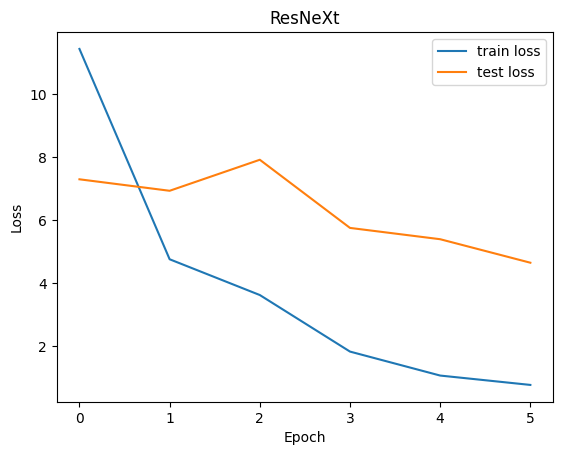

In [ ]:
plt.plot(train_loss_resnext, label='train loss')
plt.plot(test_loss_resnext, label='test loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNeXt')

## Comparison results

Text(0.5, 1.0, 'comparison of performance for three pretrained models')

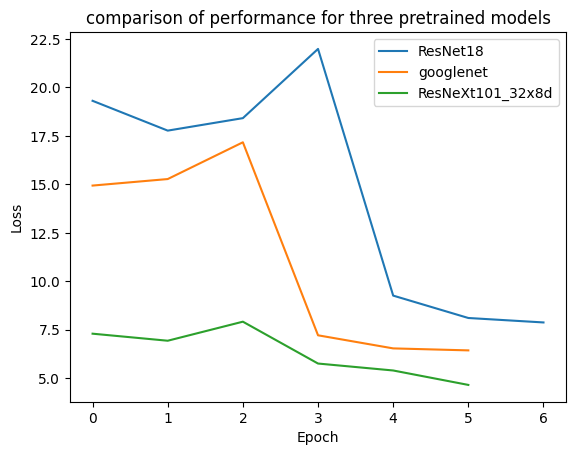

In [ ]:
plt.plot(test_loss_resnet, label='ResNet18')
plt.plot(test_loss_google, label='googlenet')
plt.plot(test_loss_resnext, label='ResNeXt101_32x8d')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('comparison of performance for three pretrained models')

Unfortunately I did not plotted accuracies for these models when run the notebook. So I'll have to gather those manually

In [ ]:
resnet_accuracy = [64.72380952380952, 74.43809523809523, 76.87619047619047, 77.60000000000001, 87.31428571428572, 88.41904761904762, 88.68571428571428]
googlenet_accuracy = [66.74285714285715, 72.45714285714286, 73.52380952380952, 86.20952380952382, 86.70476190476191, 86.70476190476191]
resnext_accuracy = [74.4, 78.47619047619048, 80.15238095238095, 84.8, 84.41904761904762, 86.47619047619047]

Text(0.5, 1.0, 'comparison of performance for three pretrained models')

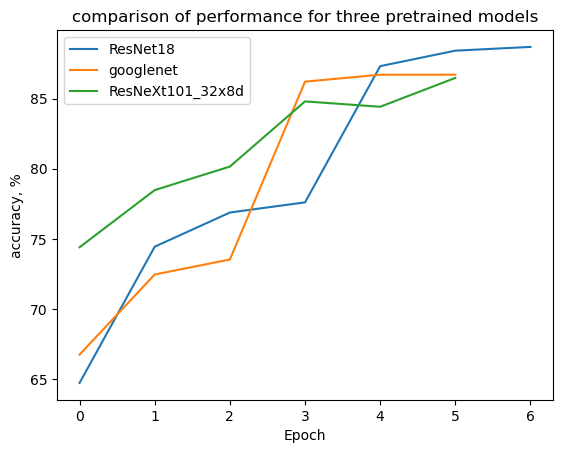

In [ ]:
plt.plot(resnet_accuracy, label='ResNet18')
plt.plot(googlenet_accuracy, label='googlenet')
plt.plot(resnext_accuracy, label='ResNeXt101_32x8d')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('accuracy, %')
plt.title('comparison of performance for three pretrained models')

Models were trained with similar parameters. It should be possible to further increase accuracy, but I'll stop for now.

It seems obvious that models performed much better after decrease of learning rate. However due to my previous experience (not explained in this notebook), it was less profitable to start training the model with lower learning rate.

Fun thing is that the more simple model got better accuracy. In this run I added one additional epoch for this model, however it performed slightly better than larger models in previous runs with 6 epochs in total as well (these results are for freshly imported model). I conclude that larger model is not always better. At least it is much more difficult to train.